# Bike Rental Count using Decision Tree

The data set is derived from a two-year usage log of a Washington, D.C. bike-sharing system called Captial Bike Sharing (CBS). Bike sharing systems are variants of traditional bicycle rentals, where the process of renting and returning is heavily automated; typically, bikes can be rented at one location and returned at another without ever having to deal with a human being. The goal is to predict the daily level of bicycle rentals from environmental and seasonal variables using decision trees.

**Data**: `bikes.csv` has the following attributes:
- date: The full date, in year-month-day format.
- season: Season of the year, 1 to 4
- year: Year, 0=2011, 1=2012
- month: Month (1 to 12)
- holiday: Whether the day is holiday or not
- weekday: Day of the week (coded by 0-6)
- workingday: 1 for working days, 0 for weekends and holidays
- weather: Weather, coded as follows:
    1. Clear to partly cloudy
    2. Mist but no heavier precipitation
    3. Light rain or snow, possibly with thunder
    4. Heavy rain or snow
- temp: Normalized temperature in Celsius. The values are derived via (t − tmin )/(tmax − tmin ); tmin = −8, tmax = +39.
- humidity: Normalized humidity ( actual humidity divided by 100 ).
- windspeed: Normalized wind speed ( actual wind speed in miles per hour divided by 67 ).
- count: Count of total bike rentals that day, including both casual and registered users.

The response variable of interest is **count**, the total number of rentals each day.

**Problem**: Build a regression tree predicting daily bike rentals from all available variables.

(i) Report the following: (a) Plot of regression tree (b) The total number of leaf nodes in the tree,
(c) Into how many different groups of days does the tree divide the data, (d) Which variables appear
in the tree, (e) Which variables are important, (f ) The MSE.

(ii) Now re-code the months so that January and February share one code, May through October
shares another, and March, April, November and December share a third. Re-estimate the regression
tree. How does the tree change (if at all)? What is the MSE? Did it improve the fit?

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.cross_validation import cross_val_score

import pydotplus
import collections
from IPython.display import Image

from matplotlib import pyplot as plt
import seaborn as sns
import copy

%matplotlib inline
sns.set()

# To turn off warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read data

In the following implementation, **date** has not been considered as a feature vector. 

In [2]:
# Read data into pandas dataframe
data = pd.read_csv('P2_data/bikes.csv')

In [3]:
feature_names = ['season', 'year', 'month', 'holiday', 'weekday', 'working_day', 
                 'weather', 'temperature', 'humidity', 'windspeed']

In [4]:
data_matrix = data.as_matrix()

X = data_matrix[:,1:-1]
y = data_matrix[:,-1]

# Split training and test set into 75-25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

m, n = X_train.shape

# Print train and test set sizes for sanity check
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(548, 10) (548,)
(183, 10) (183,)


## Decision Tree Regression

First do a dirty implementation of `DecisionTreeRegressor` from sklearn to check base accuracy and then add complexity to the model to improve its performance.
The metrics used for model evaluation are :
1. Mean Square Error (MSE)
2. R$^{2}$ Score

In [5]:
model = DecisionTreeRegressor(criterion='mse')
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mse(y_train, y_pred_train)

y_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
mse_test = mse(y_test, y_pred)

print 'Training R2 score : %.2f'%(r2_train)
print 'Training MSE score : %.2f'%(mse_train)
print 'Test R2 score : %.2f'%(r2_test)
print 'Test MSE score : %.2f'%(mse_test)

Training R2 score : 1.00
Training MSE score : 0.00
Test R2 score : 0.85
Test MSE score : 588353.58


In [6]:
# Visualizing decision tree
dot_data = export_graphviz(model, out_file=None, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

image = 'p2_decision_tree.png'
graph.write_png(image)
# Image(image)

# Please uncomment the above statement to view the tree in the jupyter notebook

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.871393 to fit



True

In [7]:
n_nodes = model.tree_.node_count
leaf_nodes = len(np.unique(model.apply(X_train)))

print 'No. of total nodes : %d'%(n_nodes)
print 'No. of leaf nodes : %d'%(leaf_nodes)

No. of total nodes : 1095
No. of leaf nodes : 548


## Cross-validation

Since the size of the tree is too large, I have used the **`cross_val_score`** function from sklearn library to perform 5-fold cross-validation on the dataset. Higher score signifies better model. For cross-validation, the maximum depth of the tree is restricted.

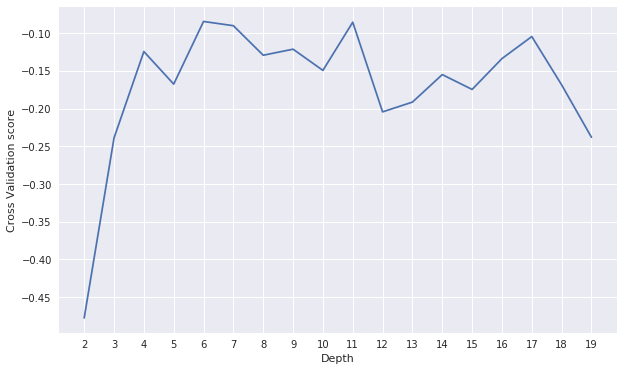

In [8]:
# List to store cross_val_score and plot it
score = []

# Max allowed depth varying from 2 to 19
depth = range(2,20)

# Cross-validation by varying maximum depth of the tree
for i in depth:
    test_model = DecisionTreeRegressor(max_depth=i, criterion='mse')
    scores = cross_val_score(estimator=test_model, X=X, y=y, cv=5)
    score.append(scores.mean())
    
# Plot to show cross_val_score vs max_depth of the tree
fig = plt.figure(figsize=(10,6))
plt.plot(depth, score)
plt.xticks(depth)
plt.xlabel('Depth')
plt.ylabel('Cross Validation score')
plt.show()

best_estimate = score.index(max(score))+2

## Improved Decision Tree

In [9]:
# Build a new tree with restriction on its maximum depth
# The best estimate is found out by cross-validation

model = DecisionTreeRegressor(max_depth=best_estimate, criterion='mse')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mse(y_train, y_pred_train)

y_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
mse_test = mse(y_test, y_pred)

print 'Training R2 score : %.2f'%(r2_train)
print 'Training MSE score : %.2f'%(mse_train)
print 'Test R2 score : %.2f'%(r2_test)
print 'Test MSE score : %.2f'%(mse_test)

Training R2 score : 0.92
Training MSE score : 285074.02
Test R2 score : 0.85
Test MSE score : 561220.15


## Visualizing decision tree

In [10]:
# Visualizing decision tree
dot_data = export_graphviz(model, out_file=None, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

image = 'p2_decision_tree.png'
graph.write_png(image)
# Image(image)

# Please uncomment the above statement to view the tree in the jupyter notebook

True

## Node Count

In [11]:
n_nodes = model.tree_.node_count
leaf_nodes = len(np.unique(model.apply(X_train)))

print 'No. of total nodes : %d'%(n_nodes)
print 'No. of leaf nodes : %d'%(leaf_nodes)

No. of total nodes : 121
No. of leaf nodes : 61


## Important features

The following list shows importance of features in decreasing order, i.e., the most important feature is shown in the first place.

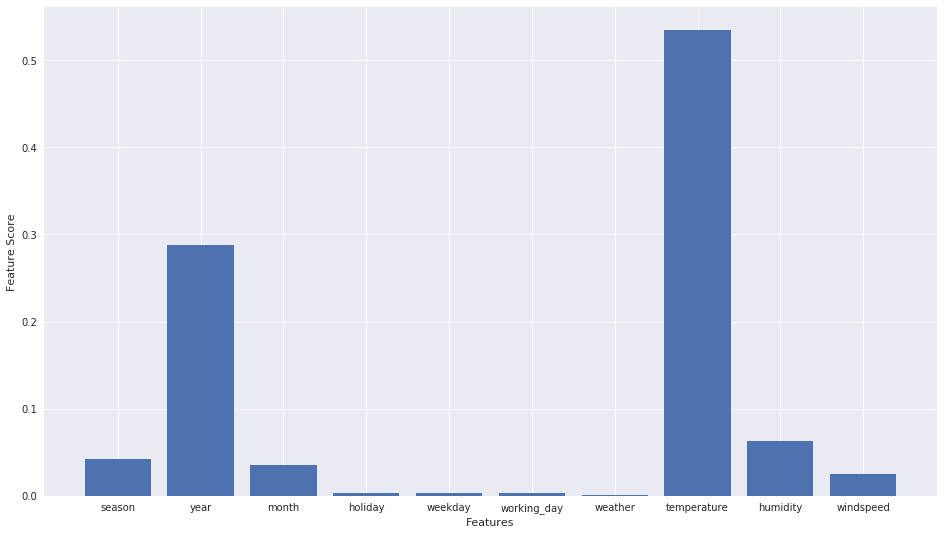

Important features: 
['temperature', 'year', 'humidity', 'season', 'month', 'windspeed', 'working_day', 'weekday', 'holiday', 'weather']


In [12]:
feature_score = list(model.feature_importances_)

fig = plt.figure(figsize=(16,9))
plt.bar(range(len(feature_score)), feature_score, align='center')
plt.xticks(range(len(feature_score)), feature_names)
plt.xlabel('Features')
plt.ylabel('Feature Score')
plt.show()

imp_features = []

for i in range(len(feature_names)):
    m = max(feature_score)
    index = feature_score.index(m)
    imp_features.append(feature_names[index])
    feature_score[index] = -1
    
print "Important features: \n",imp_features

In [13]:
feature = model.tree_.feature
print np.unique(feature)

[-2  0  1  2  3  4  5  6  7  8  9]


All the features used in the data, except 'date', shows up in the decision tree. The important features are listed below in the order of its importance :
1. Temperature
2. Year
3. Humidity
4. Season
5. Month
6. Windspeed
7. Weekday
8. Workingday
9. Holiday
10. Weather

## Random Forest

To improve the accuracy, I tried Random Forest technique for regression using `RandomForestRegressor` from sklearn. Using the base Random Forest model, the MSE has relatively improved from 674,624 to 432,886 and the R2 score has increased from 0.82 to 0.89. 

In [14]:
model = RandomForestRegressor(criterion='mse')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mse(y_train, y_pred_train)

y_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
mse_test = mse(y_test, y_pred)

print 'Training R2 score : %.2f'%(r2_train)
print 'Training MSE score : %.2f'%(mse_train)
print 'Test R2 score : %.2f'%(r2_test)
print 'Test MSE score : %.2f'%(mse_test)

Training R2 score : 0.97
Training MSE score : 103914.30
Test R2 score : 0.87
Test MSE score : 502381.29


## Cross-validation

Cross-validation is done on the Random Forest model by varying the number of trees in the forest

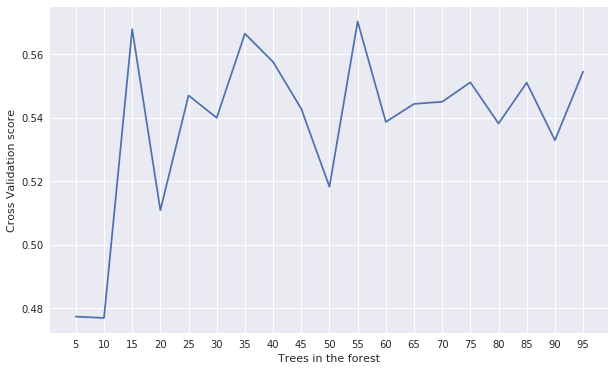

In [15]:
# List to store cross_val_score and plot it
score = []

# Number of trees in the forest varying from 5 to 100
tree_test = range(5, 100, 5)

# Cross-validation by varying number of trees in the forest
for i in tree_test:
    test_model = RandomForestRegressor(criterion='mse', n_estimators=i)
    scores = cross_val_score(estimator=test_model, X=X, y=y, cv=4)
    score.append(scores.mean())
    
# Plot to show cross_val_score vs trees in the forest
fig = plt.figure(figsize=(10,6))
plt.plot(tree_test, score)
plt.xticks(tree_test)
plt.xlabel('Trees in the forest')
plt.ylabel('Cross Validation score')
plt.show()

best_estimate = (score.index(max(score))+1)*5

## Improved Random Forest Regressor

In [16]:
# Build a new tree with restriction on the number of trees in the forest
# The best estimate is found out by cross-validation

model = RandomForestRegressor(criterion='mse', n_estimators=best_estimate)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mse(y_train, y_pred_train)

y_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
mse_test = mse(y_test, y_pred)

print 'Training R2 score : %.2f'%(r2_train)
print 'Training MSE score : %.2f'%(mse_train)
print 'Test R2 score : %.2f'%(r2_test)
print 'Test MSE score : %.2f'%(mse_test)

Training R2 score : 0.98
Training MSE score : 72323.37
Test R2 score : 0.90
Test MSE score : 399014.63


## Re-coding the data

This is the 2nd part of the problem where the month feature is re-coded as following
- January and February as 1
- May through October as 2
- March, April, November and December as 3

In [17]:
# Copying the data matrix into a new matrix for recoding
X1 = copy.copy(X)

# Recoding month feature
index = np.where((X1[:,2]==2))
X1[index,2] = 1

for i in range(5,11):
    index = np.where((X1[:,2]==i))
    X1[index,2] = 2

index = np.where((X1[:,2]==4))
X1[index,2] = 3
index = np.where((X1[:,2]==11))
X1[index,2] = 3
index = np.where((X1[:,2]==12))
X1[index,2] = 3

In [18]:
# Split training and test set into 75-25
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.25, random_state=42)

## Building Decision Tree

In [19]:
model = DecisionTreeRegressor(criterion='mse')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
mse_train = mse(y_train, y_pred_train)

y_pred = model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
mse_test = mse(y_test, y_pred)

print 'Training R2 score : %.2f'%(r2_train)
print 'Training MSE score : %.2f'%(mse_train)
print 'Test R2 score : %.2f'%(r2_test)
print 'Test MSE score : %.2f'%(mse_test)

Training R2 score : 1.00
Training MSE score : 0.00
Test R2 score : 0.84
Test MSE score : 627166.43


In [20]:
# Visualizing decision tree
dot_data = export_graphviz(model, out_file=None, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

image = 'p2_decision_tree_modified.png'
graph.write_png(image)
# Image(image)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.958127 to fit



True

In [21]:
n_nodes = model.tree_.node_count
leaf_nodes = len(np.unique(model.apply(X_train)))

print 'No. of total nodes : %d'%(n_nodes)
print 'No. of leaf nodes : %d'%(leaf_nodes)

No. of total nodes : 1093
No. of leaf nodes : 547


**If we use the base Decision Tree model, recoding the data has reduced the MSE slightly. Thus recoding the data has helped in improving the model. However the Random Forest Model improves the accuracy significantly with less MSE, without even recoding the data. 
Further the model can be improved by pruning.**